In [54]:
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
pd.options.mode.chained_assignment = None
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

movie_metadata = pd.read_csv('MovieSummaries/movie.metadata.tsv',sep='\t')

movie_metadata.columns = ['1. Wikipedia movie ID',
                          '2. Freebase movie ID',
                          '3. Movie name',
                          '4. Movie release date',
                          '5. Movie box office revenue',
                          '6. Movie runtime',
                          '7. Movie languages (Freebase ID:name tuples)',
                          '8. Movie countries (Freebase ID:name tuples)',
                          '9. Movie genres (Freebase ID:name tuples)']

character_metadata = pd.read_csv('MovieSummaries/character.metadata.tsv',sep='\t')

character_metadata.columns = ['1. Wikipedia movie ID',
                              '2. Freebase movie ID',
                              '3. Movie release date',
                              '4. Character name',
                              '5. Actor date of birth',
                              '6. Actor gender',
                              '7. Actor height (in meters)',
                              '8. Actor ethnicity (Freebase ID)',
                              '9. Actor name',
                              '10. Actor age at movie release',
                              '11. Freebase character/actor map ID',
                              '12. Freebase character ID',
                              '13. Freebase actor ID']

movie_metadata_bechdel = pd.read_csv("CMU_bechdel_added.csv")
print(movie_metadata_bechdel.shape)
movie_metadata_bechdel = movie_metadata_bechdel.drop("Unnamed: 0", axis=1)
movie_metadata_bechdel["actor_mention_score"] = pd.Series(np.zeros((movie_metadata_bechdel.shape[0],))) #add the new column

character_metadata_bechdel = character_metadata.copy(deep = True)
print("Size before:", character_metadata_bechdel.shape)
character_metadata_bechdel = character_metadata_bechdel[character_metadata_bechdel['2. Freebase movie ID'].isin(movie_metadata_bechdel["2. Freebase movie ID"].to_numpy())]
print("Size after:", character_metadata_bechdel.shape)

(6521, 11)
Size before: (450668, 13)
Size after: (72458, 13)


In [55]:
print(movie_metadata_bechdel.shape)
movie_metadata_bechdel = movie_metadata_bechdel[movie_metadata_bechdel['2. Freebase movie ID'].isin(character_metadata_bechdel["2. Freebase movie ID"].to_numpy())]
print(movie_metadata_bechdel.shape)

(6521, 11)
(6202, 11)


In [56]:
plot_summaries=pd.read_csv('MovieSummaries/plot_summaries.txt', sep='\t', header=None, names=['id', 'plot_summary'])
plot_summaries_bechdel = plot_summaries[plot_summaries['id'].isin(character_metadata_bechdel['1. Wikipedia movie ID'].to_numpy())]

plot_summaries.head()
print(plot_summaries.shape)
print(plot_summaries_bechdel.shape)

print("Movie Metadata Before sync:",movie_metadata_bechdel.shape)
movie_metadata_bechdel = movie_metadata_bechdel[movie_metadata_bechdel['1. Wikipedia movie ID'].isin(plot_summaries_bechdel["id"].to_numpy())]
print("Movie Metadata Before sync:",movie_metadata_bechdel.shape)

(42303, 2)
(5194, 2)
Movie Metadata Before sync: (6202, 11)
Movie Metadata Before sync: (5194, 11)


In [57]:
movie_idx = 255


def calculate_actor_mention_score(movie_idx):
    movie_summary = plot_summaries_bechdel.iloc[movie_idx]["plot_summary"]
    
    #Tokenize the movie summary
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(movie_summary)
    tokens = [x.lower() for x in tokens]
    tokens_freq = pd.Series(tokens).value_counts(sort=True)
    
    #align movie dataset & character dataset
    movie_id = plot_summaries_bechdel.iloc[movie_idx]["id"]
    character_list = character_metadata_bechdel[character_metadata_bechdel['1. Wikipedia movie ID'] == movie_id][['4. Character name','6. Actor gender']]
    
    character_list_processed = character_list.copy()
    character_list_processed = character_list_processed.dropna()

    #Lowercase character names
    character_list_processed["4. Character name"] = character_list_processed["4. Character name"].str.lower()

    #Split full name and only get the first name
    character_list_processed["4. Character name"] = character_list_processed["4. Character name"].str.split(' ').str[0]

    character_list_processed = character_list_processed.drop(character_list_processed[character_list_processed["4. Character name"] == "the"].index)

    character_gender_stacked = character_list_processed.drop_duplicates(subset='4. Character name', keep=False)
    character_gender_stacked_idx = character_gender_stacked.set_index("4. Character name")

    #Take the intersection between the token's frequency and movie cast
    tokens_intersection = tokens_freq[character_gender_stacked_idx.index.intersection(tokens_freq.index)]
    character_gender_stacked = character_gender_stacked.drop_duplicates()
    character_mention_freq = character_gender_stacked[character_gender_stacked["4. Character name"].isin(tokens_intersection.index)]#.drop_duplicates()

    #Add the number of character mentions in summary to the character meta-dataset
    character_mention_freq["no_mention"] = tokens_intersection.values#pd.DataFrame({'4. Character name':character_mention_freq[0], 'no_mention':character_mention_freq.values})
    character_mention_freq.columns = ["character_name", "gender", "no_mention"]
    character_list_final = character_mention_freq
    #print(character_list_final)
    
    #Group by gender and calculate total number of mentions by gender
    character_list_freq_added = character_list_final.groupby(['gender']).sum()
    if len(character_list_freq_added['no_mention'].index) != 0:
        if character_list_freq_added['no_mention'].shape[0] == 2:
            female_mention, male_mention = character_list_freq_added['no_mention'].iloc[0], character_list_freq_added['no_mention'].iloc[1] #groupby is alphabethic, index 0 = F
            mention_ratio = female_mention/(female_mention + male_mention)
        elif character_list_freq_added['no_mention'].index[0] == "M":
            mention_ratio = 0.
        elif character_list_freq_added['no_mention'].index[0] == "F":
            mention_ratio = 1.
        else:
            mention_ratio = np.nan
    else:
        mention_ratio = np.nan

    actor_mention_score = round(mention_ratio, 4)
    
    return actor_mention_score, movie_id


In [58]:

beginning = time.time()

for a in tqdm(range(movie_metadata_bechdel.shape[0]-1)):#movie_metadata_bechdel.shape[0]-1):
    actor_mention_score, movie_id = calculate_actor_mention_score(a+1)
    #print(actor_mention_score, movie_id)
    
    movie_metadata_bechdel.loc[movie_metadata_bechdel['1. Wikipedia movie ID'] == movie_id, "actor_mention_score"] = actor_mention_score
    #print(movie_metadata_bechdel.loc[movie_metadata_bechdel['1. Wikipedia movie ID'] == movie_id, "actor_mention_score"])
#print(movie_metadata_bechdel)
#print(time.time() - beginning)

100%|██████████| 5193/5193 [00:19<00:00, 261.50it/s]


In [60]:
display(movie_metadata_bechdel)
movie_metadata_bechdel.to_csv("movie_metadata_bechdel.csv", index=False)
movie_metadata_bechdel=pd.read_csv("movie_metadata_bechdel.csv")

,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score,actor_mention_score
1,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",3,0.2500
2,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",3,0.5345
5,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",3,0.2830
6,1369204,/m/04x8zs,Juarez,1939,NaN,125.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/04xvh5"": ""Costume drama"", ""/m/03bxz7"": ""B...",2,NaN
7,5664529,/m/0dyy_v,Vixen!,1968,NaN,70.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01yldk"": ""Softcore Porn"", ""/m/06b0n3"": ""S...",3,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6514,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1,0.7500
6516,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,0.1667
6517,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",3,0.5200
6519,20244619,/m/04_0j2b,Mirage,1972,NaN,82.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/016wzw"": ""Peru""}","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...",3,NaN


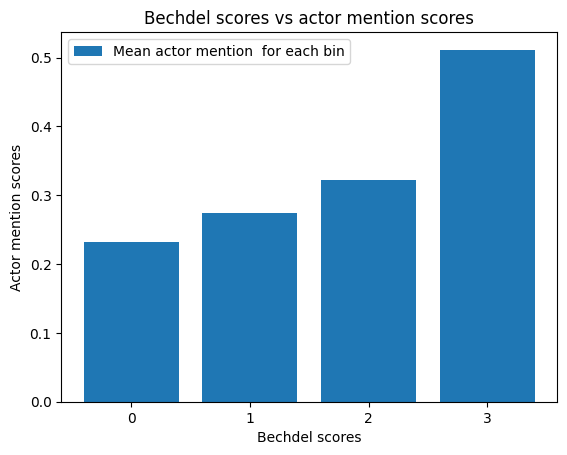

In [113]:
movie_metadata_bechdel=movie_metadata_bechdel.dropna(subset=["bechdel_score", "actor_mention_score"])
mention_group=movie_metadata_bechdel.groupby("bechdel_score")["actor_mention_score"].mean()

x=mention_group.index
plt.bar(x, mention_group.values, tick_label=x, label="Mean actor mention  for each bin")
plt.xlabel("Bechdel scores")
plt.ylabel("Actor mention scores")
plt.title("Bechdel scores vs actor mention scores")
plt.legend()
plt.show()